# Laplacian Adjusted Wasserstein Gradient Descent

The main problem we tackle within this document is to sample from a measure $\pi \propto \exp(-V)$.

The new SVGD method, which is 
$$ X_i[t+1] = X_i[t] - \frac{h}{N} \sum_{j=1}^N \nabla_x k(X_i[t], X_j[t])$$
Strangely, we do not see the output potential in this update -- this is not an accident, as we advocate specially choosing the kernel so as to make the method obtain fast convergence to $\pi$.

The magic of our method comes in implementing the kernel as
$$k(x, y) = \sum_{i=1}^\infty \frac{1}{\lambda_i} \phi(x) \phi(y),$$
where $L$ is the second-order differential operator $L \cdot = -\Delta \cdot + \langle \nabla V, \nabla \cdot \rangle$, and its eigendecomposition is $L \cdot = \sum_{i=1}^\infty \lambda_i \langle \phi_i, \cdot \rangle_{L^2(\pi)} \phi_i$.

To begin, we consider the 1-dimensional case. Throughout, when the eigendecomposition is not known, we use finite differences to approximate the differential operator on a grid. To differentiate the kernel, we also use finite differences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import seaborn as sns
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
from numpy.polynomial.hermite_e import *

def SVGD_new(kx, x0, h, max_iter, xmin, xmax, xgrid, every_iter = False,
            const_step = True, geom_step = False, poly_step = False):
    #kx is the gradient of the kernel
    #kx[i,j] is \nabla_x k(xgrid[i], xgrid[j])

    x = x0.copy()
    x = x.reshape((x.size, 1))
    xgrid = xgrid.reshape((xgrid.size, 1))
    N = x0.size
    
    if every_iter:
        conv = np.zeros((x.size, math.ceil(max_iter/every_iter)+1))
        conv[:, 0] = x.flatten()
    else:
        conv = 0
        
    counter = 1
    for i in tqdm(range(max_iter)):
        grad = np.zeros((np.size(x),1))
        # snap x values to the grid
        idx = np.argmin(np.abs(x - xgrid.T), axis = 1)
        # calculate gradient values
        for j in range(N):
            grad[j] = np.sum(kx[idx[j],idx]) / N

        if geom_step:
            if (i%500)==0:
                h = h / 2
            step = h
        if poly_step:
            step = h / math.pow(i+1, poly_step)
        if const_step:
            step = h
        
        x = x - step * grad / N
        x[x < xmin] = xmin
        x[x > xmax] = xmax
#         print(grad)
        if every_iter:
            if (i%every_iter)==0:
                conv[:, counter] = x.flatten()
                counter += 1
#             print(counter)
        # 
    if every_iter:
        return x, conv
    else:
        return x

# code taken from https://github.com/dilinwang820/Stein-Variational-Gradient-Descent,
# we modify the step size
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, 
               alpha = 0.9, debug = False, every_iter = False, 
               const_step = True, geom_step = False, poly_step = False, adagrad = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        if every_iter:
            conv = np.zeros((theta.size, math.ceil(n_iter/every_iter)+1))
            conv[:, 0] = theta.flatten()
        else:
            conv = 0
        counter = 1

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in tqdm(range(n_iter)):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1) )
            
            # if iter%200 == 0:
            #   stepsize = stepsize / 2

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # instead of adagrad, use constant step size
            
            
            if adagrad:
              # adagrad 
                if iter == 0:
                    historical_grad = historical_grad + grad_theta ** 2
                else:
                    historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
                    adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
                    theta = theta + stepsize * adj_grad 
            else:
                if geom_step:
                    if (i%500)==0:
                        stepsize = stepsize / 2
                    step = stepsize
                if poly_step:
                    step = stepsize / math.pow(i+1, poly_step)
                if const_step:
                    step = stepsize
                theta = theta + step * grad_theta
                
            if every_iter:
                if (iter%every_iter)==0:
                    conv[:, counter] = theta.flatten()
                    counter += 1

        if every_iter:
            return theta, conv
        else:
            return theta    

# 1D Gaussian Example
 
In the case of 1-dimensional Gaussians, we actually have a closed-form eigendecomposition of the differential operator. Here, we want the eigenvalues and eigenvectors of

$$L \cdot = -\frac{\partial^2}{\partial x^2} \cdot + x  \frac{\partial}{\partial x} \cdot $$

The eigenvalues are $\lambda_n = 1, 2, 3, \dots$ and the corresponding eigenfunctions are $H_n(x)$, which are the probabilists Hermite polynomials. Here are the Hermite polynomials:

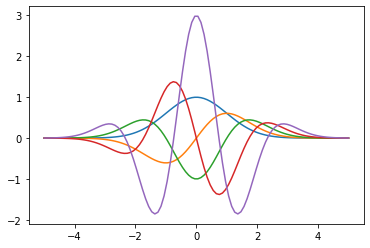

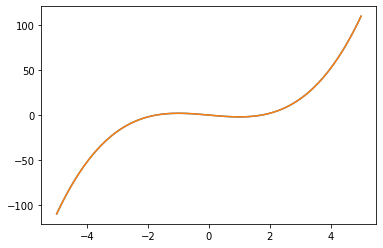

In [2]:
from numpy.polynomial.hermite_e import *
x = np.linspace(-5, 5, 100)
plt.figure()
for i in range(5):
    c = np.zeros(i+1,)
    c[i] = 1
    plt.plot(x, np.exp(-x**2 / 2) * hermeval(x, c))

plt.figure()
c = [0,0,0,1]
plt.plot(x,hermeval(x, c))
plt.plot(x,x**3 - 3*x)

The forms we are actually interested in are $H_n(x) $. The kernel is 
$$k_1(x,y) = \sum_{n=1}^\infty \frac{1}{n (n!)^2} H_n(x) H_n(y).$$ 


The derivative of $H_n$ is $H_n'(x)  = 2n H_{n-1}(x) $.

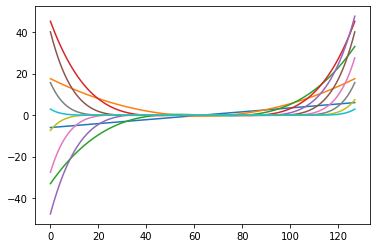

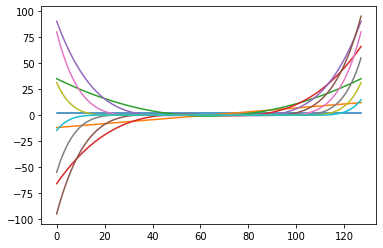

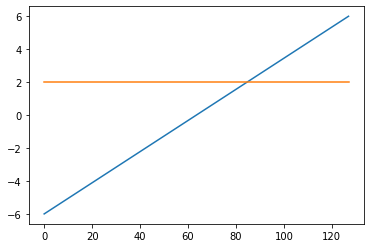

In [3]:
neig = 10
N=128                     # number of grid points
xgrid = np.linspace(-6, 6, N)
psi = np.zeros((N, neig+1))
for i in range(neig+1):
  c = np.zeros(i+1,)
  c[i] = 1
  psi[:,i] = (hermeval(xgrid, c) / math.factorial(i)) 
                # * np.exp(-0.5*xgrid**2) / (math.sqrt(2 * math.pi) ))

psiprime = np.zeros((N, neig+1))
for i in range(neig+1):
  
    if i==0:
        c = np.zeros(i+1,)
        c[i] = 1
        psiprime[:,i] = ((2 * (i) ))
                    # * np.exp(-0.5*xgrid**2) / (math.sqrt(2 * math.pi) * math.factorial(i))
                    # - xgrid * np.exp(-0.5*xgrid**2) / (2 * math.pi * math.factorial(i)))

    else:
        c = np.zeros(i+1,)
        c[i] = 1
        c2 = np.zeros(i+1,)
        c2[i-1] = 1
        psiprime[:,i] = ((2 * (i) * hermeval(xgrid, c2) / math.factorial(i)))
                    #  * np.exp(-0.5*xgrid**2) / (math.sqrt(2 * math.pi) * math.factorial(i))
                    # - hermeval(xgrid, c)*xgrid * np.exp(-0.5*xgrid**2) / (2 * math.pi * math.factorial(i)))

# throw away 0 eigenfunction
psi = psi[:,1:]
psiprime = psiprime[:,1:]

plt.figure()
for i in range(neig):
  plt.plot(psi[:,i])

plt.figure()
for i in range(neig):
  plt.plot(psiprime[:,i])


plt.figure()
plt.plot(psi[:,0])
plt.plot(psiprime[:,0])

After running the LAWGD method, and see that the generated samples match the standard normal distribution well.

100%|██████████| 5000/5000 [00:34<00:00, 146.20it/s]


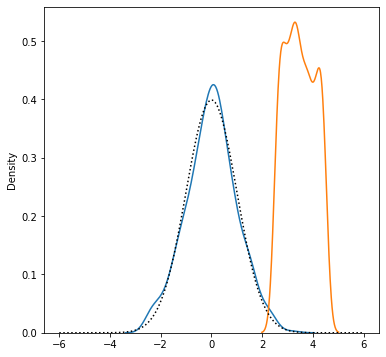

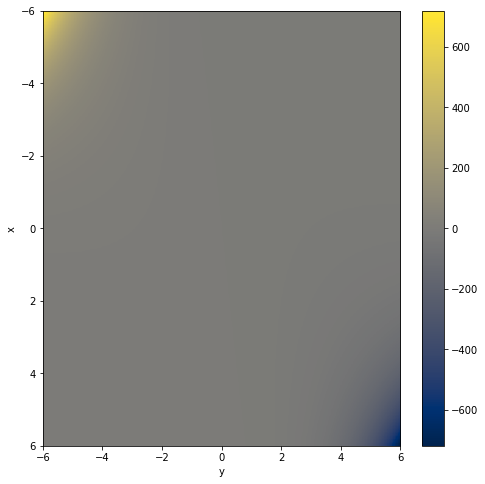

In [4]:
def V(x):
  return np.power(x, 2) / 2

neig = 150
N=128                     # number of grid points
xgrid = np.linspace(-6, 6, N)
psi = np.zeros((N, neig+1))
for i in range(neig+1):
  c = np.zeros(i+1,)
  c[i] = 1
  psi[:,i] = (hermeval(xgrid, c) / math.factorial(i)) 
              # * np.exp(-0.5*xgrid**2) / (math.sqrt(2 * math.pi) ))

psiprime = np.zeros((N, neig+1))
for i in range(neig+1):
  
  if i==0:
    c = np.zeros(i+1,)
    c[i] = 1
    psiprime[:,i] = ((2 * (i) ))
                      # * np.exp(-0.5*xgrid**2) / (math.sqrt(2 * math.pi) * math.factorial(i)))
  else:
    c = np.zeros(i+1,)
    c[i] = 1
    c2 = np.zeros(i+1,)
    c2[i-1] = 1
    psiprime[:,i] = ((2 * hermeval(xgrid, c2) / math.factorial(i)))
                      #  *np.exp(-0.5*xgrid**2) / (math.sqrt(2 * math.pi) * math.factorial(i)))

# throw away 0 eigenfunction
psi = psi[:,1:]
psiprime = psiprime[:,1:]

Lx_inv = psiprime.dot(np.diag(1 / (np.arange(neig)+1))).dot(psi.T)

num_samples = 500
x0 = 2*np.random.uniform(size=(num_samples, 1)) + 2.5
samples = SVGD_new(Lx_inv, x0, h =100, max_iter = 5000, xmin = -10, xmax = 10, xgrid = xgrid)

plt.figure(figsize = (6, 6))
sns.kdeplot(samples[:,0])
sns.kdeplot(x0[:,0])
plt.plot(xgrid, 1/math.sqrt(2*math.pi) * np.exp(-V(xgrid)), 'k:')

plt.figure(figsize = (8,8))
plt.imshow(-Lx_inv, cmap = 'cividis',extent=[-6, 6, 6, -6], aspect='auto')
#idx = plt.gca().get_xticks()
#plt.gca().set_xticks(X[(np.arange(N)==idx)])
#plt.gca().set_xticks(X)
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()

# 1D Mixture of Gaussians Example

Now we consider a more complicated example of sampling from a 1-dimensional mixture of Gaussians. Here, we do not have closed forms for the eigendecompositions, and so we must use finite differences.

In [21]:
from scipy.spatial.distance import pdist, squareform



eps = 0.01
rep = 1

maxiter = 5000
num_samples = 100
rep = 1
every_iter = 500
nstore = math.ceil(maxiter/every_iter)+1


# a bunch of code from before
m1 = 4
m2 = -3
m3 = 0
# m4 = 6


def V(x):
    return -np.log(np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) )


def dV(x):
    return (-1 / (np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) ) * 
           (np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2 * (m1 - x)/4  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) * (m2 - x) + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) * (m3 - x) ))

def d2V(x):
    return (1 / (np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) )**2  * 
           (np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2 * (m1 - x)/4  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) * (m2 - x) + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) * (m3 - x) )**2 - 
           1 / (np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) )  * 
           (np.exp(-0.5 * np.power(x-m1, 2)*1/4)/2 * (((m1 - x)/4)**2 -1/4)  + 
                    np.exp(-0.5 * np.power((x-m2), 2)) * ((m2 - x)**2 -1)  + 
                   .5 * np.exp(-0.5 * np.power((x-m3), 2)) * ((m3 - x)**2 -1)  ))


pi = math.pi

def Vs(x):
    return (dV(x)**2-2*d2V(x)) / 4


# Discrete approximation to find eigenfcns/eigenvalues

# define grid
N=256                     # number of grid points
X0, X1 =-14.0, 14.0       # grid boundaries
dx=(X1-X0)/(N-1)         # grid spacing
X=np.linspace(X0, X1, N) # grid points
X = X.reshape((N,1))
# Finite difference approximation to differential operator L
neg_Lap = np.zeros([N, N]) # -Laplacian
# Approximate -Delta f(x) by -[f(x - h) + f(x + h) - 2f(x)]/h^2
for k in range(N):
    if k>0:
        neg_Lap[k-1, k] = -1/(dx**2)
    neg_Lap[k, k] = 2/(dx**2)
    if k+1<N:
        neg_Lap[k+1, k] = -1/(dx**2)
potential_op = np.diag(Vs(X))

L = neg_Lap + potential_op/1# + np.eye(N) * 1

# find eigenfcs/eigenvalues
E, psi=np.linalg.eigh(L)

# move from Schrodinger to Langevin
psi = psi * np.outer(np.exp(V(X)/2), np.ones(N, ))


# for our kernel, we also differentiate the eigenvectors with respect to x
psi_prime = (psi[1:,] - psi[:-1,]) / dx
xgrid = X[:-1]

Einv = E
Einv = 1 / Einv

Lx_inv = psi_prime.dot(np.diag(Einv)).dot(psi[:-1,:].T)



In [22]:
reps = 1
x0 = 3*np.random.uniform(size=(num_samples, 1))-0


step_KGD = .8/dx

samples_KGD = SVGD_new(Lx_inv, x0.copy(), h = step_KGD, max_iter = maxiter, 
                                        xmin = -14, xmax = 14, xgrid = xgrid, every_iter = False,
                                       const_step = True, poly_step = False)# 0.2)
#                                        const_step = False, poly_step = 0.1)

step_SVGD = 50/maxiter
svgd = SVGD()
# x0 = 10*np.random.uniform(size=(num_samples, 1))+1

samples_SVGD = svgd.update(x0.copy(), lambda x:-dV(x), bandwidth = -1, 
                                             n_iter = maxiter, every_iter = False, stepsize = step_SVGD,
                                             const_step = True, geom_step = False)
    


100%|██████████| 5000/5000 [00:03<00:00, 1434.73it/s]


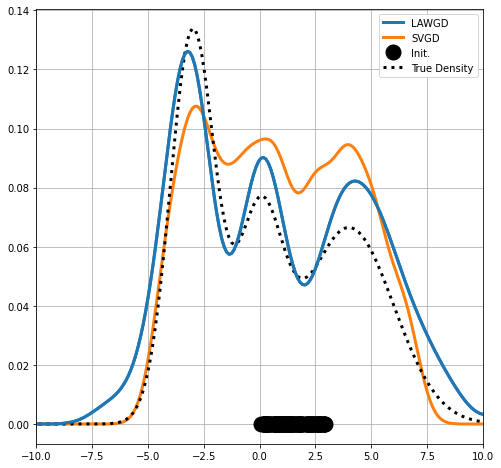

In [33]:
from scipy.stats import gaussian_kde

plt.figure(figsize = (8, 8))
kgdkde = gaussian_kde(samples_KGD[:,0], bw_method = .2)
svgdkde = gaussian_kde(samples_SVGD[:,0], bw_method = .2)
plt.plot(xgrid, kgdkde(xgrid[:,0]), linewidth = 3)
plt.plot(xgrid, svgdkde(xgrid[:,0]), linewidth = 3)
plt.plot(x0, np.zeros(x0.size), 'ok', markersize = 15)
plt.plot(xgrid, np.exp(-V(xgrid)) / (3 * math.sqrt(2*math.pi)), 'k:', linewidth = 3)
plt.plot(xgrid, kgdkde(xgrid[:,0]), linewidth = 3, color = 'tab:blue')
plt.xlim(-10,10)

plt.legend(['LAWGD','SVGD','Init.','True Density'])
plt.grid()    

# 2D Mixture of Gaussians Example

Finally, we demonstrate that the method can be run in higher dimensions with a 2D mixture of Gaussians. We note that SVGD does not exhibit good performance in this example.

In [1]:
from scipy import sparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from itertools import product
from jax import grad, jit, vmap, hessian
import math

m1 = 1 * np.ones((2,))
m2 = -1 * np.ones((2,))

# def V(x):
#     return -jnp.log(jnp.exp(-0.5 * jnp.linalg.norm(x-m1, 2))+ 
#                     jnp.exp(-0.5 * jnp.linalg.norm((x-m2), 2)))

def Vnp(x):
    n, d = x.shape
    return -np.log(np.exp(-0.5 * np.linalg.norm(x-np.outer(np.ones(n,),m1), axis = 1) ** 2)+ 
                    np.exp(-0.5 * np.linalg.norm(x-np.outer(np.ones(n,),m2), axis = 1) ** 2))


# dV = vmap(jit(grad(V)))  
# d2Vj = vmap(hessian(V))

# def d2V(x):
#   H = d2Vj(x)
#   n,_,_ = H.shape
#   out = np.zeros(n,)
#   for i in range(n):
#     out[i] = np.trace(H[i,:,:])

#   return np.array(out)
  
import autograd.numpy as anp


from autograd import grad, hessian


def V(x):
    return -anp.log(anp.exp(-0.5 * anp.power(anp.linalg.norm(x-m1), 2))+ 
                    anp.exp(-0.5 * anp.power(anp.linalg.norm(x-m2), 2)))

dVj = grad(V)
dV = lambda x: np.apply_along_axis(dVj, 0, x)

d2Vj = (hessian(V))
d2Vjtr = lambda x: np.trace(d2Vj(x))
d2V = lambda x: np.apply_along_axis(d2Vjtr, 0, x)    
    

def Vs(x):
    return np.array(np.sum(dV(x)**2, axis = 0) - 2*d2V(x)) / 4


Nx = 128
Ny = 128
N = Nx * Ny
X_range = 6
Y_range = 6
X = np.linspace(-X_range, X_range, Nx)
Y = np.linspace(-Y_range, Y_range, Ny)
dx = 2 * X_range / (Nx - 1)
dy = 2 * Y_range / (Ny - 1)
M = dict(zip(product(range(Nx), range(Ny)), range(N)))


########
# New way

def diff1(m):
  D = np.zeros((m+1, m))
  D[:m, :] = np.eye(m)
  D[1:, :] -= np.diag(np.ones(m), 0)
  return D

def lap_2d(Nx, Ny):
   # Lx, Ly are the lengths of the x and y intervals
   Dx = diff1(Nx)
   Dy = diff1(Ny)
   Ax = Dx.T.dot(Dx)
   Ax[0,:] = 0
   Ax[-1,:] = 0
   
   Ay = Dy.T.dot(Dy)
   Ay[0,:] = 0
   Ay[-1,:] = 0

   NxI = np.eye(Nx)
   NyI = np.eye(Ny)
   NxI[0,0] = 0
   NxI[-1,-1] = 0

   NyI[0,0] = 0
   NyI[-1,-1] = 0
   return sparse.kron(Ay,NxI) + sparse.kron(NyI, Ax)

X = np.linspace(-X_range, X_range, Nx)
Y = np.linspace(-Y_range, Y_range, Ny)

X2 = np.outer(X, np.ones(Nx, ))
Y2 = np.outer(np.ones(Ny, ), Y)
X2 = X2.flatten()
Y2 = Y2.flatten()

XY = np.column_stack((X2, Y2))
XY.shape

Lnew = lap_2d(Nx, Ny)/dx**2 + sparse.diags(Vs(XY.T))  



neig = 100
E, psi = sparse.linalg.eigsh(Lnew, k = neig, which = 'SM')

keep = E > 0
E = E[keep]
psi = psi[:, keep]
neig = np.sum(keep)

for i in range(neig):
  psi[:, i] *= np.exp(Vnp(XY) / 2)

new_shape = psi.shape
gradpsi_x = np.zeros(new_shape)
gradpsi_y = np.zeros(new_shape)

for i in range(1, Nx):
  for j in range(1, Ny):
    gradpsi_x[M[(i, j)], :] = (psi[M[(i, j)], :] - psi[M[(i - 1, j)], :]) / dx
    gradpsi_y[M[(i, j)], :] = (psi[M[(i, j)], :] - psi[M[(i, j - 1)], :]) / dy

for i in range(Nx):
    gradpsi_y[M[(i, 0)], :] = gradpsi_x[M[(i, 1)], :]
for j in range(Ny):
    gradpsi_x[M[(0, j)], :] = gradpsi_x[M[(1, j)], :]

   

bp1
bp1


In [2]:
def KGD_2d(x0, h, max_iter, xmin, xmax, xgrid, every_iter = False):
    N, d = x0.shape
    x = x0.copy()
    xgrid = xgrid.reshape((xgrid.size, 1))
    if every_iter:
        sample_seq = np.zeros((N, d, math.ceil(max_iter/every_iter)))
        sample_seq[:, :, 0] = x.copy()
        counter = 1
    for i in tqdm(range(max_iter)):
        grad = np.zeros((N, d))
        # snap x values to the grid
        idx0 = np.argmin(np.abs(x[:, 0].reshape((N, 1)) - xgrid.T), axis = 1)
        # snap y values to the grid
        idx1 = np.argmin(np.abs(x[:, 1].reshape((N, 1)) - xgrid.T), axis = 1)
        indices = [M[pair] for pair in zip(idx0, idx1)]
        
        # calculate gradient values
        for j in range(N):
            scaled_psi = (psi[indices, :] / E).T
            grad[j, 0] = np.sum(gradpsi_x[M[(idx0[j], idx1[j])], :].dot(scaled_psi))
            grad[j, 1] = np.sum(gradpsi_y[M[(idx0[j], idx1[j])], :].dot(scaled_psi))

        x = x - h * grad / N
        x[x < xmin] = xmin
        x[x > xmax] = xmax
        if every_iter:
            if i%every_iter == 0 and i > 0:
                sample_seq[:, :, counter] = x.copy()
                counter += 1
    if every_iter:
        return x, sample_seq
    else:
        return x

In [3]:
num_particles = 50
h = 1
x0 = 1*np.random.uniform(size=(num_particles, 2))-np.outer(np.ones(num_particles,), np.array([3, -3]))

sample_KGD, sample_seq_KGD = KGD_2d(x0, h, max_iter=5001, xmin=-5, xmax=5, xgrid=X, every_iter=1) 

100%|██████████| 5001/5001 [00:31<00:00, 156.40it/s]


In [4]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

# code taken from https://github.com/dilinwang820/Stein-Variational-Gradient-Descent,
# we modify the step size

class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, 
               alpha = 0.9, debug = False, every_iter = False, const_step = False,
               pc_step = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0)
        n, d = theta.shape
        
        if every_iter:
          conv = np.zeros((n, d, math.ceil(n_iter/every_iter)+1))
          conv[:, :, 0] = theta
        else:
          conv = 0
        counter = 1

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        print("getting started")
        for iter in tqdm(range(n_iter)):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1) )
            
            # if iter%200 == 0:
            #   stepsize = stepsize / 2

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = -1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # # instead of adagrad, use constant step size
            # theta = theta + stepsize * grad_theta
            
            # if (iter%500) == 0:
            #   iter = iter/2
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad
            if every_iter:
                conv[:, :, iter + 1] = theta
        if every_iter:
          return theta, conv
        return theta
    
def V(x):
    return -jnp.log(jnp.exp(-0.5 * jnp.linalg.norm(x-m1, 2, axis=1))+ 
                    jnp.exp(-0.5 * jnp.linalg.norm(x-m2, 2, axis=1)))
    
# def dV(x):
#   n = x.shape[0]
#   return ((np.exp(-0.5 * np.linalg.norm(x-m1, 2, axis=1)).reshape(n, 1) * (x - m1) +
#            np.exp(-0.5 * np.linalg.norm(x-m2, 2, axis=1)).reshape(n, 1) * (x - m2)) /
#            (np.exp(-0.5 * np.linalg.norm(x-m1, 2, axis=1)) + 
#                     np.exp(-0.5 * np.linalg.norm(x-m2, 2, axis=1))).reshape(n, 1))

def dV(x):
#   n = x.shape[0]
  return ((np.outer(np.exp(-0.5 * np.linalg.norm(x-m1, 2, axis=1) ** 2), np.ones(2,))* (x - m1) +
           np.outer(np.exp(-0.5 * np.linalg.norm(x-m2, 2, axis=1) ** 2), np.ones(2,)) * (x - m2)) /
           np.outer((np.exp(-0.5 * np.linalg.norm(x-m1, 2, axis=1) ** 2) + 
                    np.exp(-0.5 * np.linalg.norm(x-m2, 2, axis=1)) ** 2), np.ones(2,)))

    
h = .1
svgd = SVGD()
sample_SVGD, sample_seq_SVGD = svgd.update(x0, lambda x: -dV(x), bandwidth = -1, n_iter = 20001, every_iter=True)

  1%|          | 190/20001 [00:00<00:10, 1894.94it/s]

getting started


100%|██████████| 20001/20001 [00:11<00:00, 1672.50it/s]


Now that we have the samples, we can plot their trajectories and compare LAWGD to SVGD. We see that the performance of LAWGD is much better than that of SVGD. Beyond this, we see that initially LAWGD converges extremely fast to the target distribution, which may be a result of the "strong uniform ergodicity" property we mention in the paper.

/usr/local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


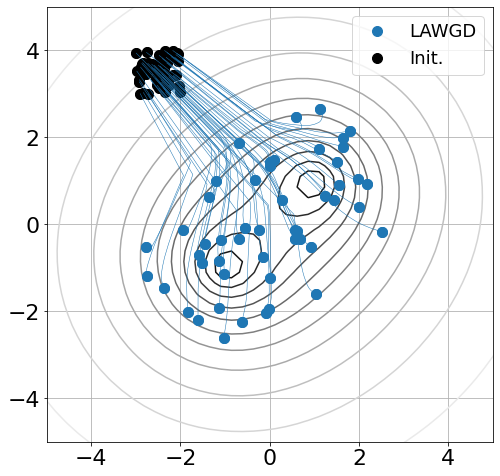

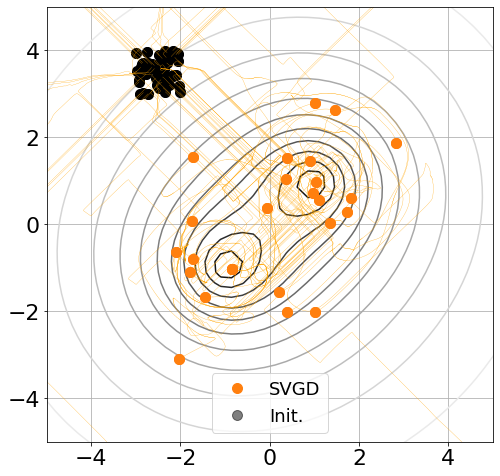

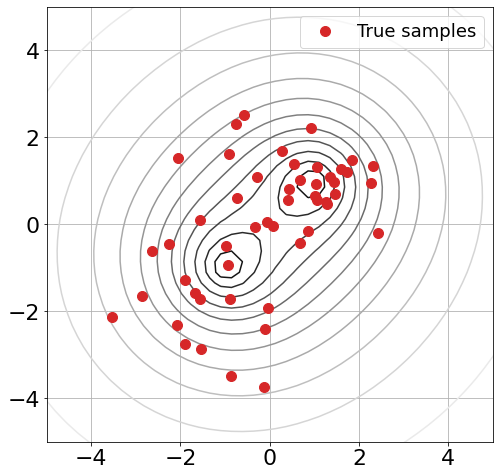

In [5]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

target_density = lambda x: np.exp(-V(x)) / (4 * math.pi)
gridpts = 50
xs = np.linspace(-6, 6, num=gridpts)
ys = np.linspace(-6, 6, num=gridpts)
zs = np.zeros(shape=(gridpts, gridpts))
for i in range(gridpts):
  for j in range(gridpts):
    zs[j, i] = target_density(np.array([[xs[i], ys[j]]]))
XS, YS = np.meshgrid(xs, ys)

p, ax = plt.subplots()
p.set_figheight(8)
p.set_figwidth(8)




plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()


plt.plot(sample_seq_KGD[:, 0, -1], sample_seq_KGD[:, 1, -1], 'o', color = 'tab:blue', markersize = 10, alpha = 1)
plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)
plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 0.5)
for i in range(num_particles):
  plt.plot(sample_seq_KGD[i, 0, :], sample_seq_KGD[i, 1, :], color="tab:blue", linewidth=0.5, alpha = 1)
plt.plot(sample_seq_KGD[:, 0, -1], sample_seq_KGD[:, 1, -1], 'o', color = 'tab:blue', markersize = 10, alpha = 1)
plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
plt.legend(['LAWGD', 'Init.'])

plt.savefig('trajectories_law_2d.pdf')

########

p, ax = plt.subplots()
p.set_figheight(8)
p.set_figwidth(8)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()
# for legend
plt.plot(sample_seq_SVGD[:, 0, -1], sample_seq_SVGD[:, 1, -1], 'o', color = 'tab:orange', markersize = 10, alpha = 1)
plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 0.5)

plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)
for i in range(num_particles):
  plt.plot(sample_seq_SVGD[i, 0, :], sample_seq_SVGD[i, 1, :], color="orange", linewidth=0.25, alpha = 1)
plt.plot(sample_seq_SVGD[:, 0, -1], sample_seq_SVGD[:, 1, -1], 'o', color = 'tab:orange', markersize = 10, alpha = 1)
plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
plt.legend(['SVGD', 'Init.'])
# # plt.savefig('trajectories_svgd_2d.pdf')

########

x1 = np.random.normal(loc = 1, size = (25, 2)) 
x2 = np.random.normal(loc = -1, size = (25, 2))
plt.figure(figsize = (8,8))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.plot(x1[:,0], x1[:,1], 'o', color = 'tab:red',  markersize = 10)
plt.plot(x2[:,0], x2[:,1], 'o', color = 'tab:red', markersize = 10,)
plt.grid()
plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
plt.legend(['True samples'])
# plt.savefig('truesamp_2d.pdf')



## Animation

The following code can be used to generate an animation of our results.

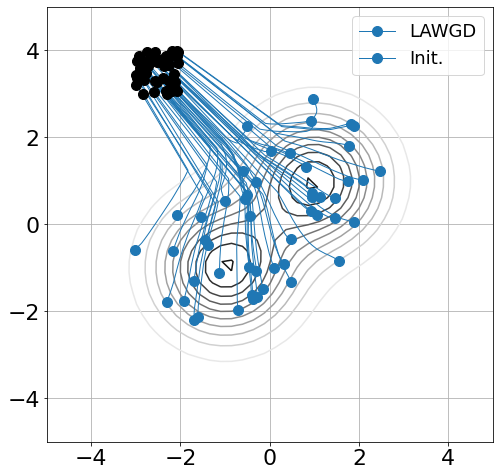

In [57]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
seq = sample_seq_KGD
color = "tab:blue"
num_iter = seq.shape[2]
num_particles = 50
lines = []
for i in range(num_particles):
  lines.append(ax.plot([], [], color=color, linewidth=1, alpha=1, marker="o", markersize=10)[0])

target_density = lambda x: np.exp(-V(x)) / (4 * math.pi)
gridpts = 50
xs = np.linspace(-6, 6, num=gridpts)
ys = np.linspace(-6, 6, num=gridpts)
zs = np.zeros(shape=(gridpts, gridpts))
for i in range(gridpts):
  for j in range(gridpts):
    zs[j, i] = target_density(np.array([[xs[i], ys[j]]]))
XS, YS = np.meshgrid(xs, ys)

fig.set_figheight(8)
fig.set_figwidth(8)

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()

plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)

plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
plt.legend(['LAWGD', 'Init.'])

def init():
  for line in lines:
    line.set_data([], [])
  return lines

def update(frame):
  # plt.cla()
  # plt.plot(seq[:, 0, frame], seq[:, 1, frame], 'o', color=color, markersize=10, alpha = 1)
  for i, line in enumerate(lines):
    line.set_data(seq[i, 0, :frame], seq[i, 1, :frame])
    line.set_markevery(np.array([frame - 1]))
  return lines

ani = FuncAnimation(fig, update, frames=range(0, num_iter, 100),
                    init_func=init, blit=True, interval=50)
ani.save("ani_lawgd.mp4")
plt.show()

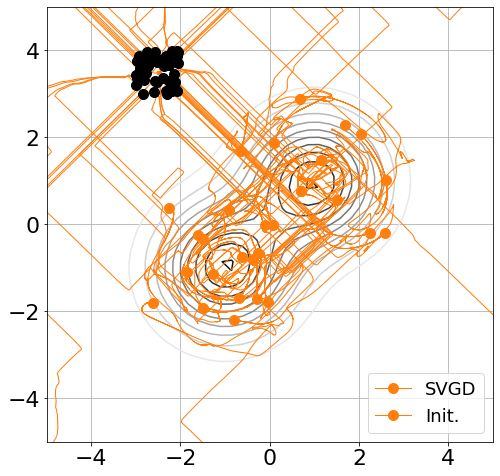

In [58]:
fig, ax = plt.subplots()
seq = sample_seq_SVGD
color = "tab:orange"
num_iter = seq.shape[2]
num_particles = 50
lines = []
for i in range(num_particles):
  lines.append(ax.plot([], [], color=color, linewidth=1, alpha=1, marker="o", markersize=10)[0])

target_density = lambda x: np.exp(-V(x)) / (4 * math.pi)
gridpts = 50
xs = np.linspace(-6, 6, num=gridpts)
ys = np.linspace(-6, 6, num=gridpts)
zs = np.zeros(shape=(gridpts, gridpts))
for i in range(gridpts):
  for j in range(gridpts):
    zs[j, i] = target_density(np.array([[xs[i], ys[j]]]))
XS, YS = np.meshgrid(xs, ys)

fig.set_figheight(8)
fig.set_figwidth(8)

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()

plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)

plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
plt.legend(['SVGD', 'Init.'])

def init():
  for line in lines:
    line.set_data([], [])
  return lines

def update(frame):
  # plt.cla()
  # plt.plot(seq[:, 0, frame], seq[:, 1, frame], 'o', color=color, markersize=10, alpha = 1)
  for i, line in enumerate(lines):
    line.set_data(seq[i, 0, :frame], seq[i, 1, :frame])
    line.set_markevery(np.array([frame - 1]))
  return lines

ani = FuncAnimation(fig, update, frames=range(0, num_iter, 100),
                    init_func=init, blit=True, interval=50)
ani.save("ani_svgd.mp4")
plt.show()

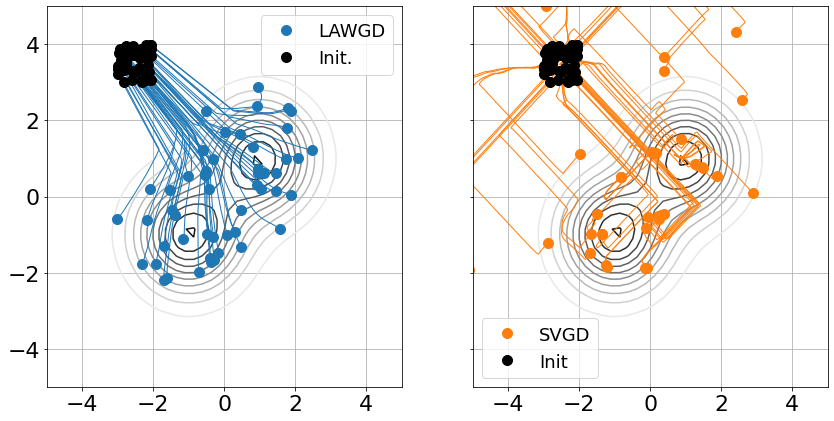

In [59]:
# Animate LAWGD and SVGD side by side

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].plot([-10], [-10], 'o', color="tab:blue", markersize = 10)
ax[0].plot([-10], [-10], 'o', color="black", markersize = 10)
ax[1].plot([-10], [-10], 'o', color="tab:orange", markersize = 10)
ax[1].plot([-10], [-10], 'o', color="black", markersize = 10)
num_iter = sample_seq_KGD.shape[2]
num_particles = 50
lawgd_lines = []
svgd_lines = []
for i in range(num_particles):
  lawgd_lines.append(ax[0].plot([], [], color="tab:blue", linewidth=1, alpha=1, marker="o", markersize=10)[0])
  svgd_lines.append(ax[1].plot([], [], color="tab:orange", linewidth=1, alpha=1, marker="o", markersize=10)[0])

target_density = lambda x: np.exp(-V(x)) / (4 * math.pi)
gridpts = 50
xs = np.linspace(-6, 6, num=gridpts)
ys = np.linspace(-6, 6, num=gridpts)
zs = np.zeros(shape=(gridpts, gridpts))
for i in range(gridpts):
  for j in range(gridpts):
    zs[j, i] = target_density(np.array([[xs[i], ys[j]]]))
XS, YS = np.meshgrid(xs, ys)

fig.set_figheight(7)
fig.set_figwidth(14)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

for i in range(2):
  ax[i].grid()
  ax[i].plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)
  ax[i].contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
ax[0].legend(['LAWGD', 'Init.'])
ax[1].legend(['SVGD', 'Init'])

def init():
  for line in lawgd_lines + svgd_lines:
    line.set_data([], [])
  return lawgd_lines + svgd_lines

def update(frame):
  # plt.cla()
  # plt.plot(seq[:, 0, frame], seq[:, 1, frame], 'o', color=color, markersize=10, alpha = 1)
  for i, line in enumerate(lawgd_lines):
    line.set_data(sample_seq_KGD[i, 0, :frame], sample_seq_KGD[i, 1, :frame])
    line.set_markevery(np.array([frame - 1]))
  for i, line in enumerate(svgd_lines):
    line.set_data(sample_seq_SVGD[i, 0, :frame], sample_seq_SVGD[i, 1, :frame])
    line.set_markevery(np.array([frame - 1]))
  return lawgd_lines + svgd_lines

ani = FuncAnimation(fig, update, frames=range(0, num_iter, 100),
                    init_func=init, blit=True, interval=50)
ani.save("ani_both.mp4")
plt.show()

## Figures comparing speed of convergence

Finally, the following figures are used in the paper to compare speed of convergence.

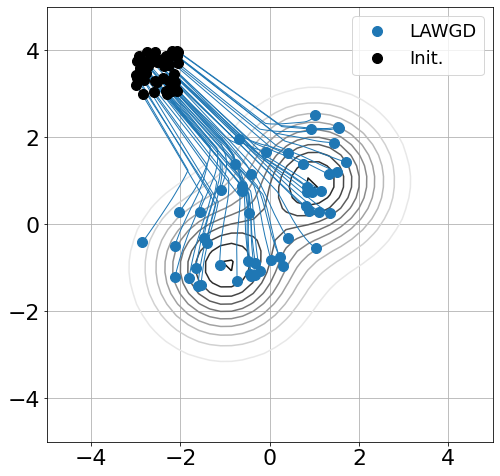

In [60]:
fig, ax = plt.subplots()
seq = sample_seq_KGD
name = "LAWGD"
color = "tab:blue"
iterations = [100, 200, 1000, 2000]

plt.plot([-10], [-10], 'o', color=color, markersize = 10)
plt.plot([-10], [-10], 'o', color="black", markersize = 10)

num_iter = seq.shape[2]
num_particles = 50
lines = []
for i in range(num_particles):
  lines.append(ax.plot([], [], color=color, linewidth=1, alpha=1, marker="o", markersize=10)[0])

target_density = lambda x: np.exp(-V(x)) / (4 * math.pi)
gridpts = 50
xs = np.linspace(-6, 6, num=gridpts)
ys = np.linspace(-6, 6, num=gridpts)
zs = np.zeros(shape=(gridpts, gridpts))
for i in range(gridpts):
  for j in range(gridpts):
    zs[j, i] = target_density(np.array([[xs[i], ys[j]]]))
XS, YS = np.meshgrid(xs, ys)

fig.set_figheight(8)
fig.set_figwidth(8)

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()

plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)

plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))

plt.legend([name, 'Init.'])

for it_num in iterations:
  for i, line in enumerate(lines):
    line.set_data(seq[i, 0, :it_num], seq[i, 1, :it_num])
    line.set_markevery(np.array([it_num - 1]))
  plt.savefig(name + str(it_num) + ".pdf")

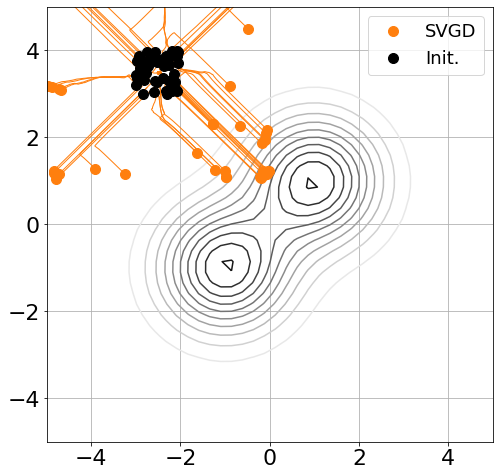

In [61]:
fig, ax = plt.subplots()
seq = sample_seq_SVGD
name = "SVGD"
color = "tab:orange"
iterations = [100, 200, 1000, 2000]

plt.plot([-10], [-10], 'o', color=color, markersize = 10)
plt.plot([-10], [-10], 'o', color="black", markersize = 10)

num_iter = seq.shape[2]
num_particles = 50
lines = []
for i in range(num_particles):
  lines.append(ax.plot([], [], color=color, linewidth=1, alpha=1, marker="o", markersize=10)[0])

target_density = lambda x: np.exp(-V(x)) / (4 * math.pi)
gridpts = 50
xs = np.linspace(-6, 6, num=gridpts)
ys = np.linspace(-6, 6, num=gridpts)
zs = np.zeros(shape=(gridpts, gridpts))
for i in range(gridpts):
  for j in range(gridpts):
    zs[j, i] = target_density(np.array([[xs[i], ys[j]]]))
XS, YS = np.meshgrid(xs, ys)

fig.set_figheight(8)
fig.set_figwidth(8)

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()

plt.plot(x0[:,0], x0[:,1], 'ok', markersize = 10, alpha = 1)

plt.contour(XS, YS, zs, levels=12 , cmap='binary', extent = (-2.5, 2.5, -2.5, 2.5))
plt.legend([name, 'Init.'])

for it_num in iterations:
  for i, line in enumerate(lines):
    line.set_data(seq[i, 0, :it_num], seq[i, 1, :it_num])
    line.set_markevery(np.array([it_num - 1]))
  plt.savefig(name + str(it_num) + ".pdf")